In [1]:
from functools import reduce
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [3]:
# Initialize to avoid load error, set
# actual values at execution step.
YEARS = []  
OFFICES = []


''' Remove top features not shared between 
    different datasets to prevent errors.'''
def removeUncommonColumns(nested_dict):
    print("Removing uncommon columns...")
    
    # Flatten and find common columns
    all_dfs = [df for year in nested_dict for df in nested_dict[year].values()]
    common_cols = set(all_dfs[0].columns)
    for df in all_dfs[1:]:
        common_cols &= set(df.columns)
    
    # Safely trim all dataframes
    for year in nested_dict:
        for office in nested_dict[year]:
            df = nested_dict[year][office]
            existing_cols = [col for col in common_cols if col in df.columns]
            nested_dict[year][office] = df[existing_cols]

    print('Done.')
    
    return nested_dict


''' Pull the engineered feature data along with its
    target for each year and office.'''
def makeDatasets(years, offices, remove_xtra_cols=False):
    print('Making datasets...')
    
    df_datasets = {}
    
    for year in years:
        print(f'Processing year {year}...')
        df_datasets[year] = {}
        
        for office in offices:
            print(f'Processing office {office}...')

            df = pd.read_csv('data/generated_data/07_ml_features_' + year + '_' + office + '.csv', low_memory=False)

            # for col in df.columns:
                # if col.startswith(('S', 'B', 'D')):
                    # df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
                    # invalid_values = ['(X)', '-', 'N/A', 'null', '']
                    # df[col] = df[col].replace(invalid_values, np.nan)

            
            # For running this function separately
            # on other years and offices outside of
            # the main execution loop.
            # For example, 2024 has columns that other
            # years do not, which causes errors.
            if remove_xtra_cols:
                df = df.drop(columns=remove_xtra_cols, errors='ignore')

            df_datasets[year][office] = df
    
    df_datasets = removeUncommonColumns(df_datasets)

    print('Done.')
    
    return df_datasets


''' Split features and target into X
    and y variables with some cleanup.'''
def makeFeaturesTargets(df):
    print(f'Making features and target...')
    
    y = df[['partisan_temp']]
    X = df.drop(columns=['standardized_id_num', 'partisan_temp', 'partisan_temp_change_curr'])
    X = X.replace(['-', '(X)', 'N/A', 'null', ''], pd.NA)

    print('Done.')
    return X, y


''' Pipeline to impute and encode categorical
    variables, as well as scale, etc.'''
def fitModel(X, y):
    print(f'Fitting model...')

    categorical_cols = [
        'office_code',
        'partisanship_lean_curr',
        'partisanship_lean_prev',
        'partisanship_lean_change_prev',
    ]

    categorical_cols = [col for col in categorical_cols if col in X.columns]
    numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

    numeric_cols = [col for col in numeric_cols if col not in categorical_cols]

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)

    print('Done.')

    return model, X_train, X_test, y_train, y_test, numeric_cols


def makePredictions(X_test, model):
    print(f'Making predictions...')
    y_pred = model.predict(X_test)
    print('Done.')
    return y_pred


def plotAccuracy(y_test, y_pred):
    print(f'Plotting accuracy...')
    plt.figure(figsize=(12, 9))
    plt.scatter(y_test, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Prediction Accuracy")
    plt.grid(True)
    print('Done.')
    return plt


def featureCoeff(model):
    print(f'Computing feature coefficients...')
    sort_column = 'coefficient'

    coefficients = model.named_steps['regressor'].coef_.flatten()
    feature_names, clean_names = get_feature_names(model)

    coef_df = pd.DataFrame({
        'feature': clean_names,
        'raw_feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    }).sort_values(by='coefficient', ascending=False)

    top_features = coef_df[coef_df['coefficient'] > 0].sort_values(by='coefficient', ascending=False).head(TOP_N_FEATURES)
    print('Done.')
    return top_features


def plotFeatureCoeff(top_features, n_features):
    print(f'Plotting feature coefficients...')
    plt.figure(figsize=(12, 18))
    bars = plt.barh(top_features['feature'][:n_features], top_features['coefficient'][:n_features])
    plt.xlabel('Coefficient Value')
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.title(f'Top {TOP_N_FEATURES} Most Influential Features (Linear Regression)')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.grid(True, axis='x', linestyle=':', alpha=0.7)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    print('Done.')
    return plt


def get_feature_names(model):
    print("Getting feature names...")

    preprocessor = model.named_steps['preprocessor']
    feature_names = preprocessor.get_feature_names_out()

    # Store both prefixed and cleaned names
    cleaned_names = [name.split('__', 1)[-1] for name in feature_names]

    print(f"Done. Retrieved {len(feature_names)} feature names.")
    return feature_names, cleaned_names


def mergeTopFeatures(top_features_lists):
    print(f'Creating common top features using clean names...')
    from itertools import chain

    # Make clean names
    normalized_lists = []
    for item in top_features_lists:
        if isinstance(item, list):
            normalized_lists.append(item)
        elif hasattr(item, 'columns') and 'feature' in item.columns:
            normalized_lists.append(item['feature'].tolist())
        else:
            raise ValueError("Each item must be a list or a DataFrame with a 'feature' column")

    # Find intersection
    common_features = set(normalized_lists[0])
    for feature_list in normalized_lists[1:]:
        common_features.intersection_update(feature_list)

    # Preserve order
    seen = set()
    merged_common_ordered = []

    for item in chain.from_iterable(normalized_lists):
        if item in common_features and item not in seen:
            seen.add(item)
            merged_common_ordered.append(item)

    print('Done.')
    return merged_common_ordered


def one_hot_encode_selected(df, columns_to_encode):
    df = df.copy()
    if not columns_to_encode:
        return df
    encoded = pd.get_dummies(df[columns_to_encode], prefix=columns_to_encode)
    df = df.drop(columns=columns_to_encode)
    return pd.concat([df, encoded], axis=1)

#### Execution

In [19]:
YEARS = ['2018', '2020', '2022']
OFFICES = ['US_House']
TOP_N_FEATURES = 250

census_datasets = [
    'b02001_race', 'b04007_ancestry', 'b05012_nativity_us', 'b08303_travel_time_work', 'b25003_housing_rentership', 
    'dp02_selected_social_characteristics', 'dp03_selected_economic_characteristics', 'dp04_housing_characteristics', 'dp05_age_race', 
    's0101_age_sex', 's1101_households_families', 's1201_marital_status', 's1501_educational_attainment', 's1701_income_poverty', 
    's1903_median_income', 's2101_veteran_status', 's2201_food_stamps', 's2301_employment_status', 's2401_occupation_sex', 
    's2403_industry_sex', 's2501_occupancy_characteristics', 's2701_health_insurance', 's2503_financial_characteristics',
]

#### Feature Analysis

In [24]:
DROP_FEATURES = False

drop_features = [
    'office_code', 'dem_share_prev', 'rep_share_prev', 'oth_share_prev', 
    'dem_share_change_prev', 'rep_share_change_prev', 'oth_share_change_prev', 
    'dem_votes_change_prev', 'rep_votes_change_prev', 'oth_votes_change_prev', 
    'registered_voters_change_prev', 'turnout_pct_change_prev', 
    'partisan_temp_prev', 'partisan_temp_change_prev', 
    'partisanship_lean_prev', 'partisanship_lean_change_prev', 'partisanship_lean_change_amount_prev' 
]

Making datasets...
Processing year 2018...
Processing office US_House...
Processing year 2020...
Processing office US_House...
Processing year 2022...
Processing office US_House...
Removing uncommon columns...
Done.
Done.
Processing year 2018...
Processing office US_House...
Making features and target...
Done.
Training over 2792 features...
Fitting model...
Done.
Making predictions...
Done.
Mean Squared Error: 0.01104140218991497
R2 Score: 0.948892616716871
Plotting accuracy...
Done.


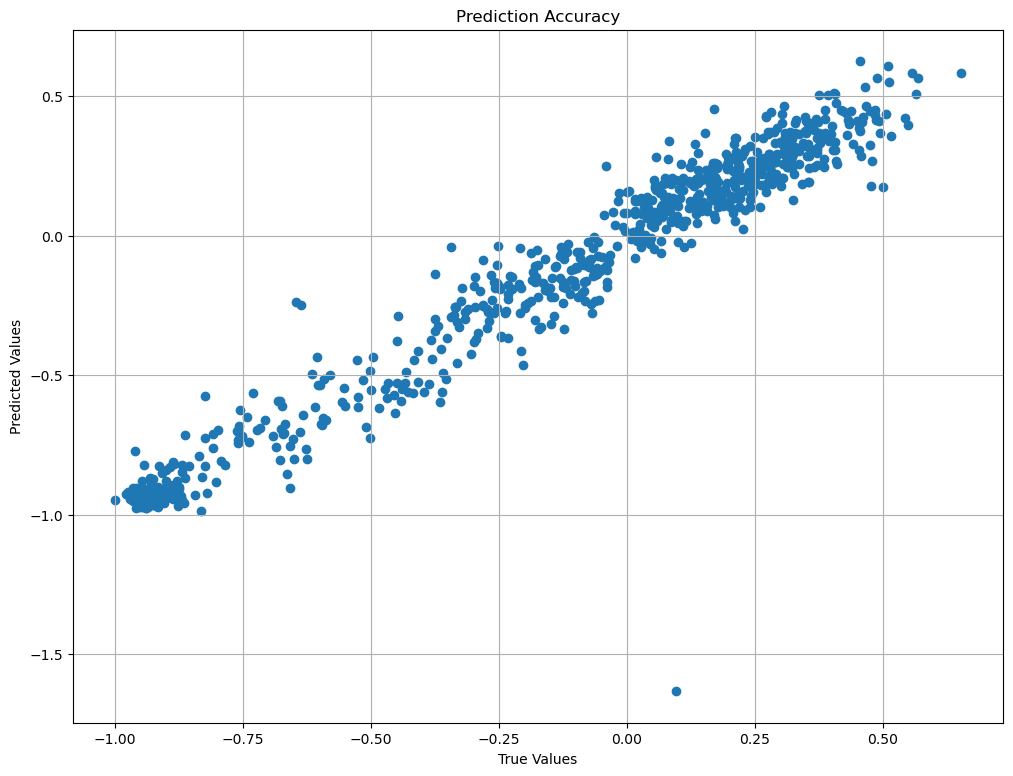

Computing feature coefficients...
Getting feature names...
Done. Retrieved 1269 feature names.
Done.
Top 20 features:              feature          raw_feature   coefficient  abs_coefficient
970      B05012_002E     num__B05012_002E  8.285230e+08     8.285230e+08
861   S2101_C03_026E  num__S2101_C03_026E  8.091609e+08     8.091609e+08
18    S2401_C02_010E  num__S2401_C02_010E  7.343585e+08     7.343585e+08
1081  S2701_C02_003E  num__S2701_C02_003E  7.322523e+08     7.322523e+08
629   S2501_C01_004E  num__S2501_C01_004E  7.311960e+08     7.311960e+08
1055  S0101_C01_014E  num__S0101_C01_014E  7.250689e+08     7.250689e+08
546   S2301_C01_009E  num__S2301_C01_009E  7.249821e+08     7.249821e+08
510   S0101_C03_026E  num__S0101_C03_026E  7.131171e+08     7.131171e+08
575   S0101_C01_011E  num__S0101_C01_011E  7.055431e+08     7.055431e+08
903   S0101_C01_029E  num__S0101_C01_029E  7.013662e+08     7.013662e+08
1132  S2701_C01_031E  num__S2701_C01_031E  6.805990e+08     6.805990e+08
739   

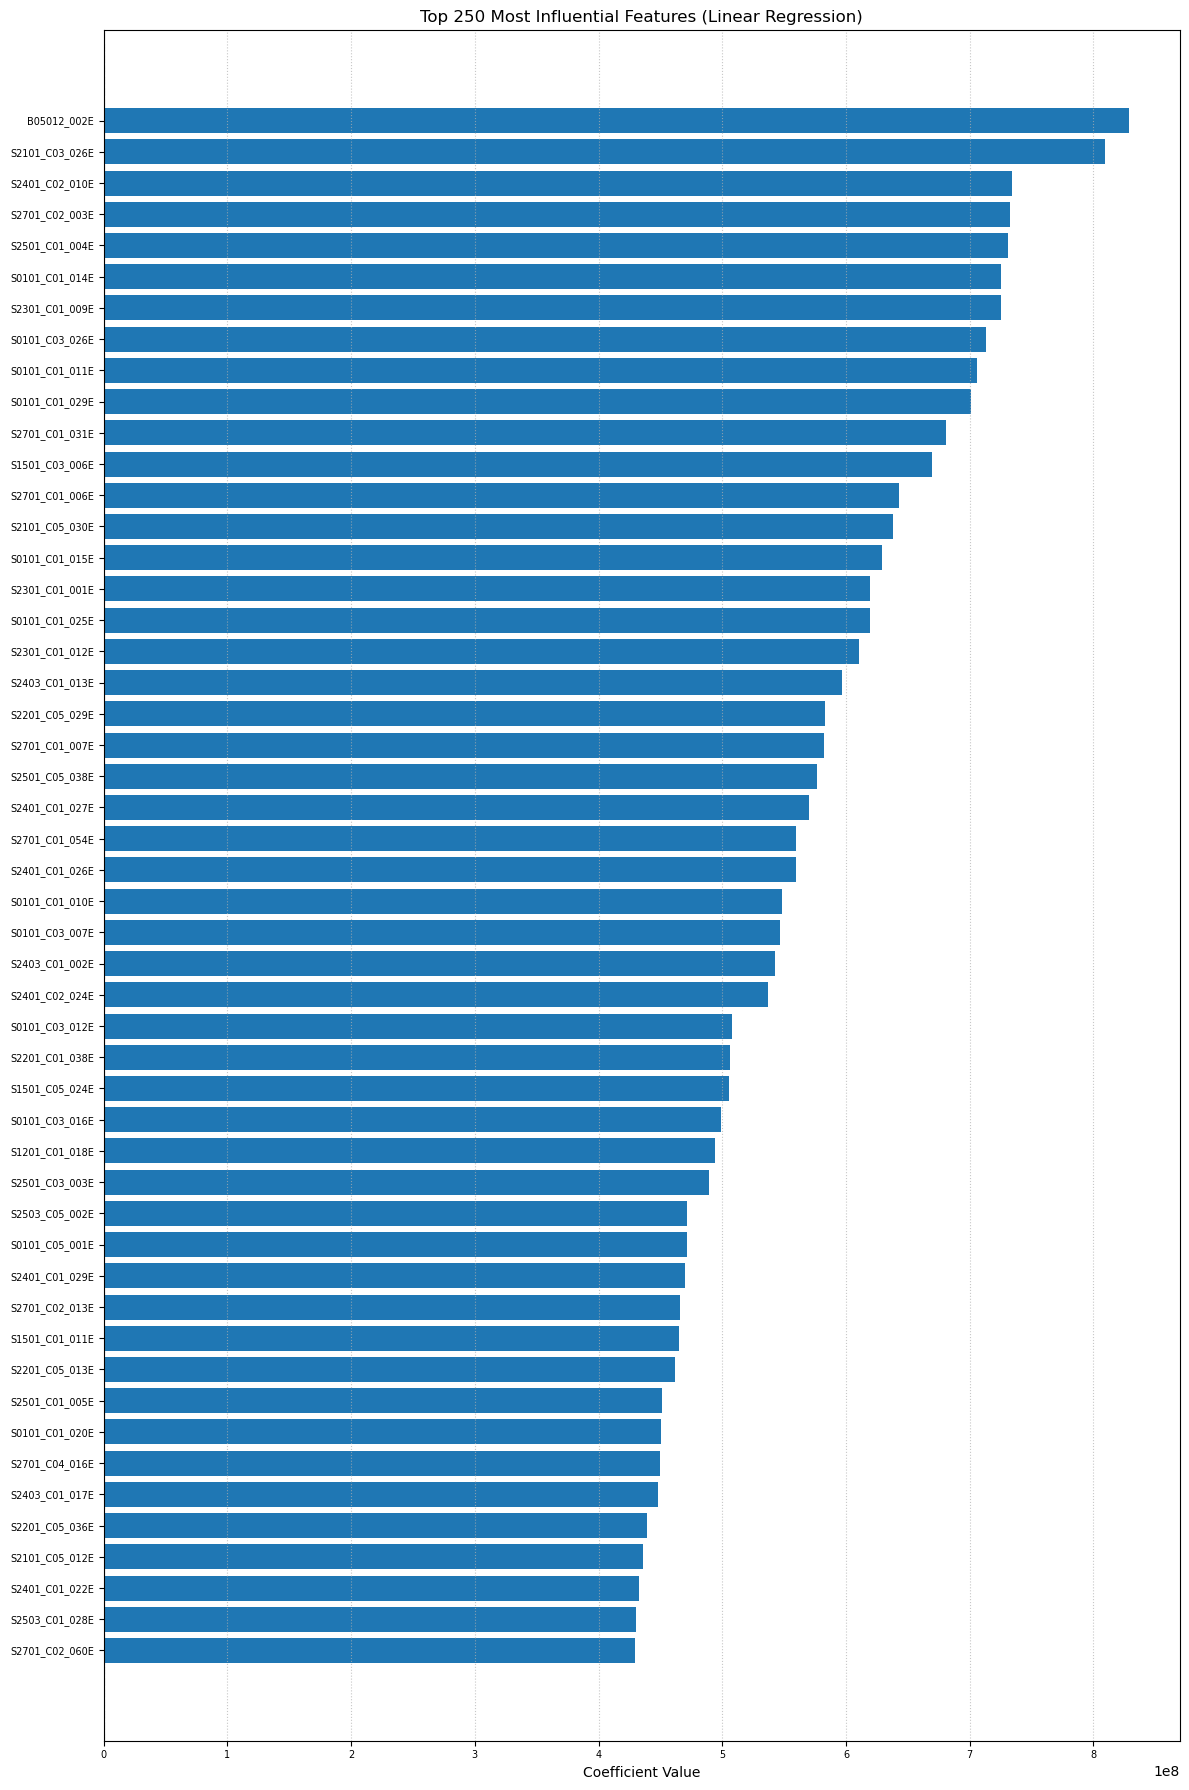

Processing year 2020...
Processing office US_House...
Making features and target...
Done.
Training over 2792 features...
Fitting model...
Done.
Making predictions...
Done.
Mean Squared Error: 0.005243662000554082
R2 Score: 0.9790459250057039
Plotting accuracy...
Done.


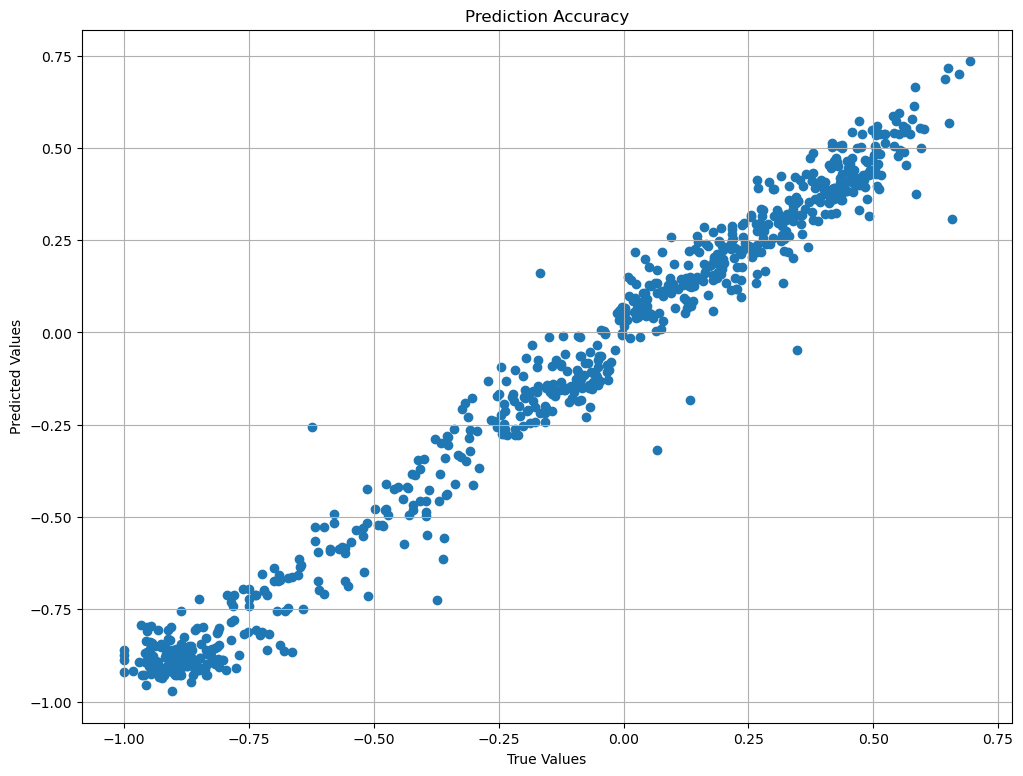

Computing feature coefficients...
Getting feature names...
Done. Retrieved 1273 feature names.
Done.
Top 20 features:              feature          raw_feature   coefficient  abs_coefficient
954   S1501_C05_030E  num__S1501_C05_030E  9.064085e+08     9.064085e+08
654   S2701_C01_048E  num__S2701_C01_048E  6.934727e+08     6.934727e+08
601   S0101_C03_028E  num__S0101_C03_028E  6.536885e+08     6.536885e+08
20    S1501_C01_036E  num__S1501_C01_036E  6.061100e+08     6.061100e+08
999   S2101_C01_026E  num__S2101_C01_026E  6.010977e+08     6.010977e+08
898   S2701_C01_051E  num__S2701_C01_051E  5.750230e+08     5.750230e+08
1055  S2701_C01_049E  num__S2701_C01_049E  5.328162e+08     5.328162e+08
782   S2101_C01_001E  num__S2101_C01_001E  4.541808e+08     4.541808e+08
1014  S2701_C02_057E  num__S2701_C02_057E  4.458195e+08     4.458195e+08
701   S2501_C05_020E  num__S2501_C05_020E  4.423879e+08     4.423879e+08
425   S2101_C01_040E  num__S2101_C01_040E  4.335094e+08     4.335094e+08
683   

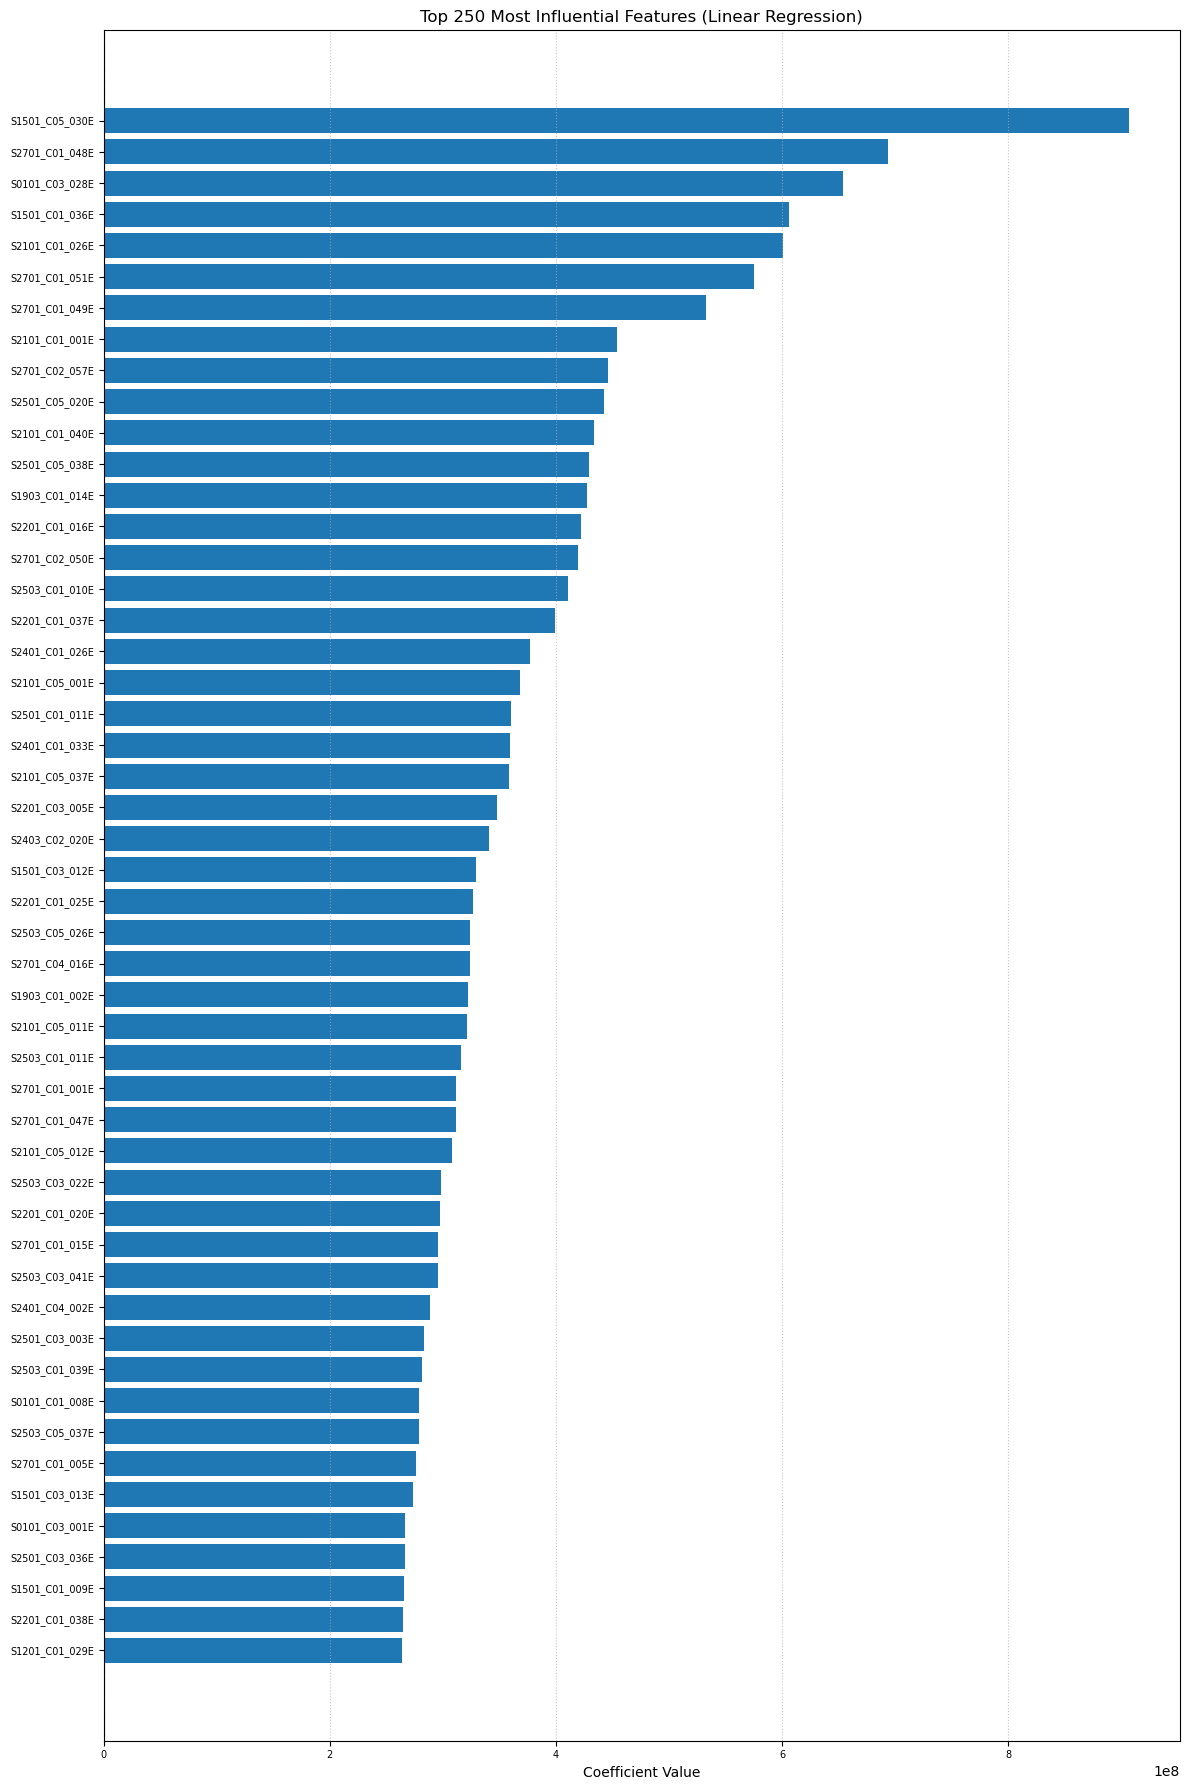

Processing year 2022...
Processing office US_House...
Making features and target...
Done.
Training over 2792 features...
Fitting model...
Done.
Making predictions...
Done.
Mean Squared Error: 0.008314727442944207
R2 Score: 0.9644366145894393
Plotting accuracy...
Done.


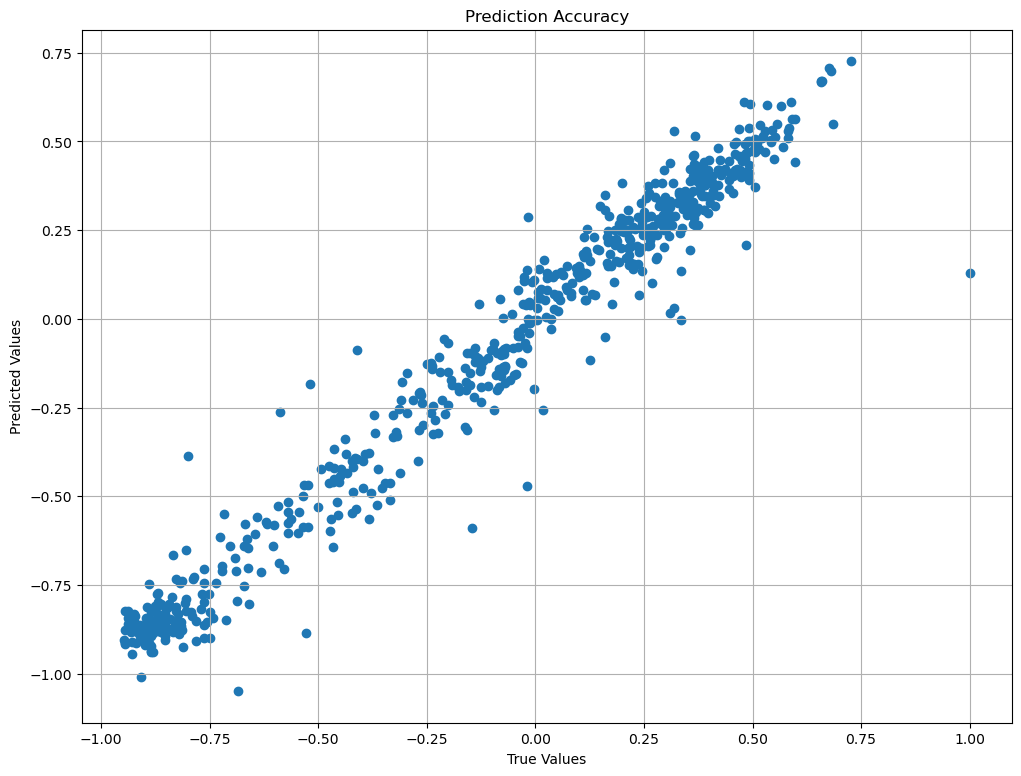

Computing feature coefficients...
Getting feature names...
Done. Retrieved 1274 feature names.
Done.
Top 20 features:                  feature              raw_feature   coefficient  \
18        S1501_C03_029E      num__S1501_C03_029E  4.427339e+09   
696       S2101_C05_001E      num__S2101_C05_001E  1.932023e+09   
691       S2403_C01_017E      num__S2403_C01_017E  1.903512e+09   
904       S2301_C01_001E      num__S2301_C01_001E  1.559064e+09   
853       S0101_C01_025E      num__S0101_C01_025E  1.559064e+09   
447       S2501_C01_003E      num__S2501_C01_003E  1.548100e+09   
268       S1501_C05_006E      num__S1501_C05_006E  1.487987e+09   
879       S1201_C01_007E      num__S1201_C01_007E  1.433663e+09   
938       S2201_C01_037E      num__S2201_C01_037E  1.369422e+09   
1100      S2503_C05_028E      num__S2503_C05_028E  1.369215e+09   
178       S2501_C03_010E      num__S2501_C03_010E  1.366302e+09   
1008      S2701_C02_014E      num__S2701_C02_014E  1.312165e+09   
301       S

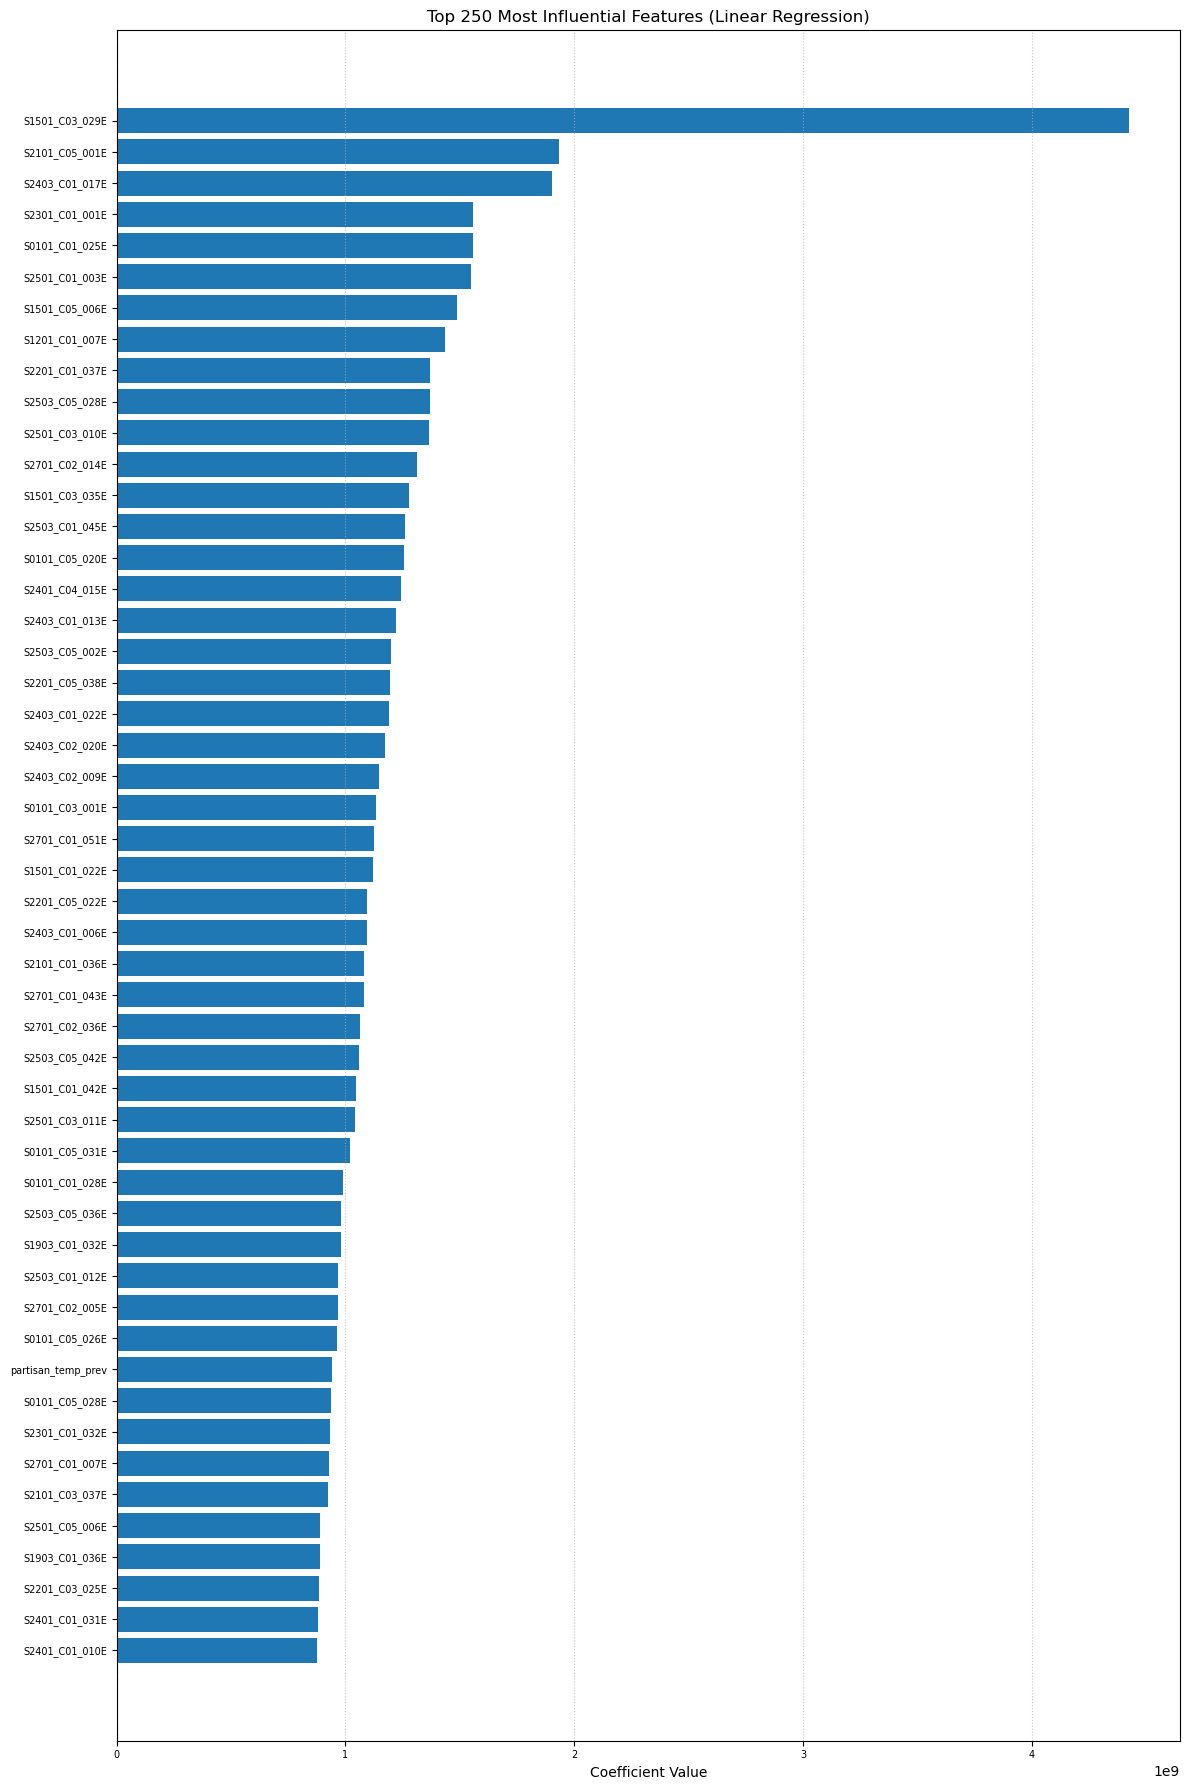

In [25]:
df_datasets = makeDatasets(YEARS, OFFICES)

top_features_lists = []

for year in YEARS:
    print(f'Processing year {year}...')
    
    for office in OFFICES:
        print(f'Processing office {office}...')
        
        df = df_datasets[year][office].copy()
        X, y = makeFeaturesTargets(df)

        if DROP_FEATURES:
            X = X.drop(columns=drop_features)

        print(f"Training over {len(X.columns)} features...")

        model, X_train, X_test, y_train, y_test, numeric_cols = fitModel(X, y)
        y_pred = makePredictions(X_test, model)
        
        mse = mean_squared_error(y_test, y_pred)
        print("Mean Squared Error:", mse)

        r2 = model.score(X_test, y_test)
        print("R2 Score:", r2)
        
        plt = plotAccuracy(y_test, y_pred)
        plt.show()
        
        top_features = featureCoeff(model)
        print(f'Top 20 features: {top_features[:50]}')

        top_features_lists.append(top_features['feature'].tolist())
        
        plt = plotFeatureCoeff(top_features, 50)
        plt.show()

#### Use only top_n features
Train from scratch on the top features detected from above steps

In [11]:
# # Merge top features from cycles
# top_features_all = mergeTopFeatures(top_features_lists)
# print(f'Num top features: {len(top_features_all)}')

# print(f'Top feature count: {len(top_features_all)}')
# print(f'Top 10 features: {top_features_all}')

#### Aggregate Historical Training
Do we have data leakage here? Maybe not, if we train on historical data and
<br>run a separate test on newer data in a following step. Say, here we
train 2018-2022, <br>and then in another cell test 2024 on the same model

Making datasets...
Processing year 2018...
Processing office US_House...
Processing year 2020...
Processing office US_House...
Processing year 2022...
Processing office US_House...
Removing uncommon columns...
Done.
Done.
Processing year 2018...
Processing office US_House...
Processing year 2020...
Processing office US_House...
Processing year 2022...
Processing office US_House...
Making features and target...
Done.
Getting feature names...
Done. Retrieved 1274 feature names.
Fitting model...
Done.
Making predictions...
Done.
Mean Squared Error: 0.019578508055878487
R2 Score: 0.9162136099444788
Plotting accuracy...
Done.


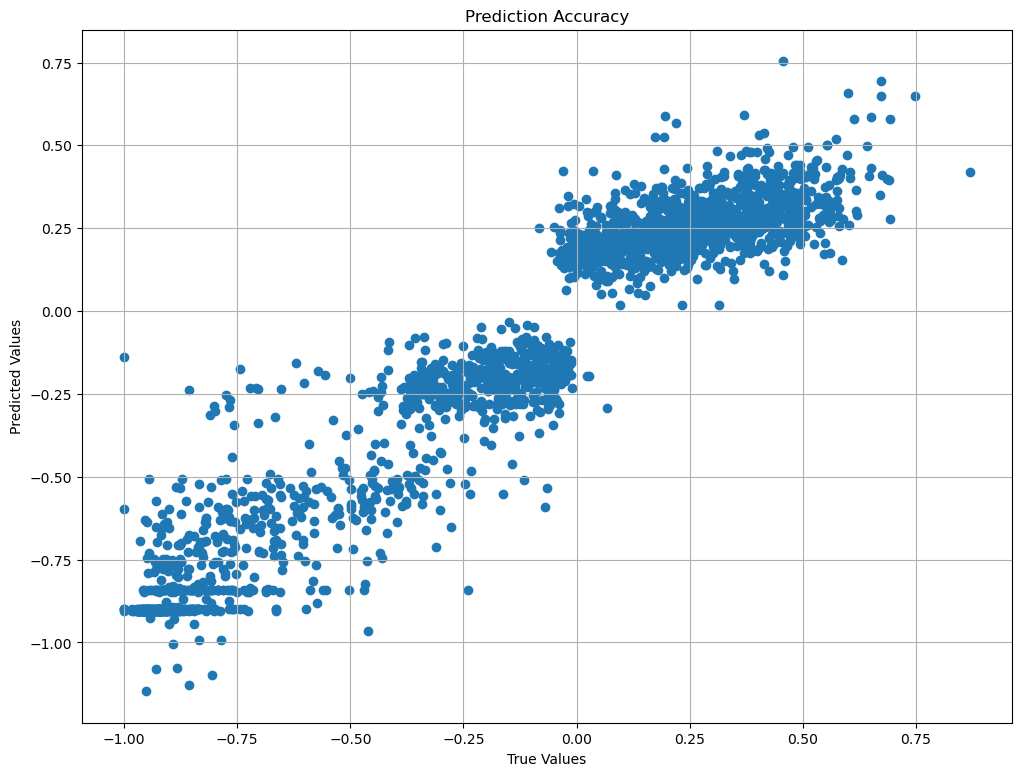

In [26]:
# Later in the notebook we pull 2024 data, which does not include the columns
# below for 2018, 2020, and 2022. If these columns are left in, errors are
# thrown when processing 2024 data. This must be done at this step, since
# the model is being trained here.

# When using ALL features, some columns are not present in 2024 and must be removed
# missing_2024_cols = ['S1101_C03_014E', 'S1101_C02_014E', 'S1101_C04_014E']
missing_2024_cols = False

df_datasets = makeDatasets(YEARS, OFFICES, missing_2024_cols)

dfs = []
for year in YEARS:
    print(f'Processing year {year}...')
    for office in OFFICES:
        print(f'Processing office {office}...')
        dfs.append(df_datasets[year][office].copy())
        
df = pd.concat(dfs, axis=0, ignore_index=True)
X, y = makeFeaturesTargets(df)

if DROP_FEATURES:
    X = X.drop(columns=drop_features)

# Get the correct, clean feature names.
feature_names, clean_names = get_feature_names(model)
top_feature_mask = [name in top_features_all for name in clean_names]
X = X.replace({pd.NA: np.nan})
X_transformed = model.named_steps['preprocessor'].transform(X)
X_transformed_df = pd.DataFrame(X_transformed, columns=clean_names)
X = X_transformed_df[top_features_all]

model, X_train, X_test, y_train, y_test, numeric_cols = fitModel(X, y)
y_pred = makePredictions(X_test, model)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = model.score(X_test, y_test)
print("R2 Score:", r2)

plt = plotAccuracy(y_test, y_pred)
plt.show()

# top_features = featureCoeff(model)
# print(f'Top 10 features: {top_features[:10]}')

# plt = plotFeatureCoeff(top_features, 50)
# plt.show()

#### Individual Cycle Future Prediction
This functionality requires objects and variables initiatlized in previous cells, including <code>model</code>
<br>and <code>numeric_cols</code>. When using aggregated cycle data, the model should be trained on historical
<br>elections only, previous to the upcoming election that is being predicted.

Making datasets...
Processing year 2024...
Processing office US_House...
Removing uncommon columns...
Done.
Done.
Making features and target...
Done.
Getting feature names...
Done. Retrieved 161 feature names.
Mean Squared Error: 1.8162007664205487e+26
R2 Score: 0.9162136099444788
Plotting accuracy...
Done.


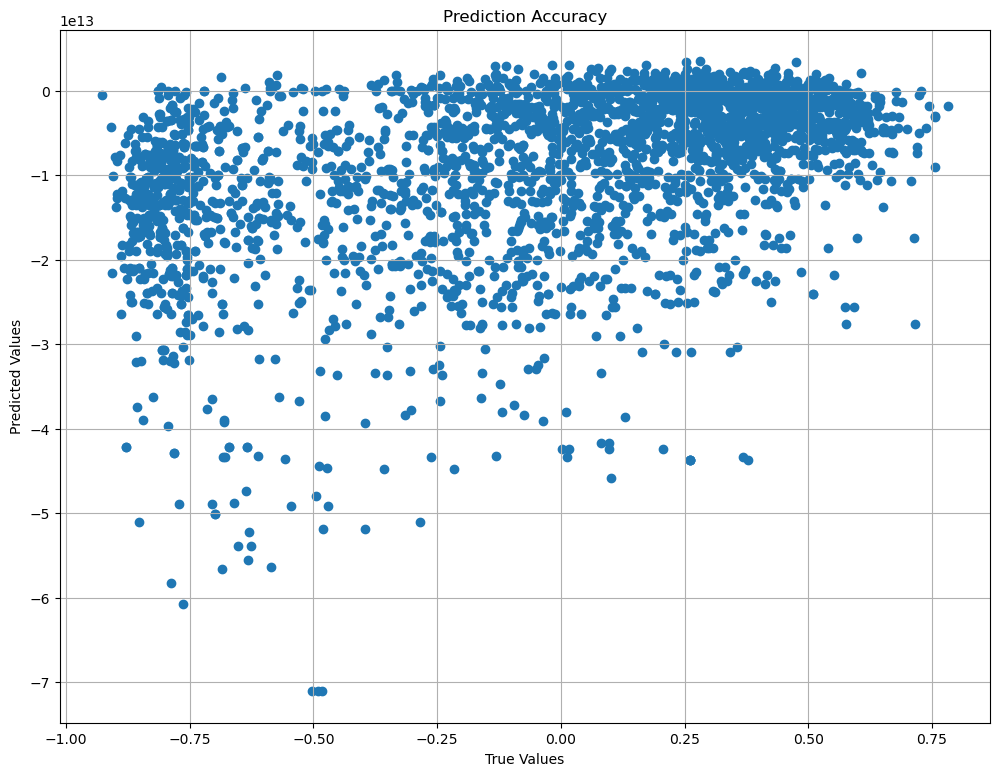

In [27]:
year = '2024'
office = 'US_House'

df_datasets = makeDatasets([year], [office])

df = df_datasets[year][office].copy()
X, y = makeFeaturesTargets(df)

if DROP_FEATURES:
    X = X.drop(columns=drop_features)

# Ensure X is in correct format
X = X.replace({pd.NA: np.nan})
_, clean_names = get_feature_names(model)
for col in clean_names:
    if col not in X.columns:
        X[col] = np.nan
X = X[clean_names]

# Apply preprocessing before prediction
X_transformed = model.named_steps['preprocessor'].transform(X)
y_pred = model.named_steps['regressor'].predict(X_transformed)

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

r2 = model.score(X_test, y_test)
print("R2 Score:", r2)

plt = plotAccuracy(y, y_pred)
plt.show()

# top_features = featureCoeff(model)
# print(f'Top 10 features: {top_features[:10]}')

# plt = plotFeatureCoeff(top_features, 50)
# plt.show()